In [1]:
import arcpy
import datetime
#import json
import logging
import os
import re
import sys

from arcgis.gis import GIS
from arcgis import features
from getpass import getpass
#from getpass import getuser
from IPython.display import display
from pathlib import Path

In [2]:
#Set to False if ArcGIS Enterprise cert is not valid
PortalCertVerification = False

In [3]:
#https://stackoverflow.com/questions/273192/how-can-i-create-a-directory-if-it-does-not-exist
def createFolder(folderPath):
    if not os.path.exists(folderPath):
        try:
            os.makedirs(folderPath)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

def renameFile(currentAttachmentPath, newAttachmentPath):
    #Rename file - ensure new attachment path does not exist already
    if not os.path.exists(newAttachmentPath):
        os.rename(currentAttachmentPath, newAttachmentPath)
        logger.info('{} being renamed as {}'.format(currentAttachmentPath, newAttachmentPath))
    else:
        logger.warning('Not able to rename {} as {} because file already exists. Removing {}'.format(currentAttachmentPath, newAttachmentPath, currentAttachmentPath))
        os.remove(currentAttachmentPath)

[Excellent tutorial on Python Logging](https://realpython.com/python-logging/)

In [4]:
SaveLogsTo = input(f'Enter directory path for log file ')
#Setup logging - levels are DEBUG,INFO,WARNING,ERROR,CRITICAL
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logFileName = datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
fileHandler = logging.handlers.RotatingFileHandler(f'{SaveLogsTo}/{logFileName}.log', maxBytes=100000, backupCount=5)
formatter = logging.Formatter('%(asctime)s %(levelname)s %(relativeCreated)d \n%(filename)s %(module)s %(funcName)s %(lineno)d \n%(message)s\n')
fileHandler.setFormatter(formatter)
logger.addHandler(fileHandler)

Enter directory path for log file C:\Users\friendde\Documents\ArcGIS\Projects\UpdateDamageAssesment\Logger


Sign-in to the portal of your choice

In [28]:
response = input(f'Do you want to use the active portal? {(arcpy.GetActivePortalURL())} [y or n] ')
if response.upper() in "YES":
    username=input("Enter User Name ")
    gis = GIS(arcpy.GetActivePortalURL(), username, password=(getpass()))
else:
    portalURL=input("Enter Portal Address ")
    username=input("Enter User Name ")
    gis = GIS(portalURL, username, password=getpass())
portal_desc = arcpy.GetPortalDescription(portalURL)
print(f'Portal Name - {portal_desc["portalName"]}\nConnected to {portal_desc["portalHostname"]} as user {username}')

Do you want to use the active portal? https://gru.maps.arcgis.com/ [y or n] n
Enter Portal Address https://wms.gru.com/portal
Enter User Name siteadmin
········
Portal Name - Portal for ArcGIS
Connected to None as user siteadmin


[Searching for Content](https://developers.arcgis.com/python/guide/accessing-and-creating-content/#searching-for-content)
https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.ContentManager.search
https://developers.arcgis.com/rest/users-groups-and-items/search-reference.htm
https://developers.arcgis.com/rest/users-groups-and-items/search.htm
https://developers.arcgis.com/rest/users-groups-and-items/search-reference.htm
https://developers.arcgis.com/rest/users-groups-and-items/item.htm
https://developers.arcgis.com/rest/users-groups-and-items/common-parameters.htm


In [37]:
# search and list all items owned by connected user
# search(query, item_type=None, sort_field='avgRating', sort_order='desc', max_items=10, outside_org=False, categories=None, category_filters=None)
#query=f'owner:{username}'
query=f'access:public'
#query='""'
outsideOrg = False
itemType="Feature Layer"
sortField="title"
sortOrder="asc"
# default max__items is 10
maxItems=100
searchResult = gis.content.search(query,itemType,sortField,sortOrder,maxItems,outsideOrg)
#searchResult = gis.content.search(query,itemType,outside_org = False)
searchResult

INFO:arcgis._impl.portalpy:Searching items (q="" AND  (type:"feature service") accountid:0123456789ABCDEF, bbox=None, start=1, num=100)


[<Item title:"2016 Population Density by Congressional District" type:Feature Layer Collection owner:esri_livingatlas>,
 <Item title:"2016 USA Traffic Counts" type:Feature Layer Collection owner:esri_livingatlas>,
 <Item title:"Algeria Country Boundary 2014" type:Feature Layer Collection owner:esri_livingatlas>,
 <Item title:"Algeria Wilayat Boundaries 2014" type:Feature Layer Collection owner:esri_livingatlas>,
 <Item title:"AlpineAuditTest" type:Feature Layer Collection owner:FRIENDDE@GRUADMIN>,
 <Item title:"Argentina Country Boundary 2014" type:Feature Layer Collection owner:esri_livingatlas>,
 <Item title:"Argentina Departamento Boundaries 2014" type:Feature Layer Collection owner:esri_livingatlas>,
 <Item title:"Argentina Provincia Boundaries 2014" type:Feature Layer Collection owner:esri_livingatlas>,
 <Item title:"Australia Country Boundary 2014" type:Feature Layer Collection owner:esri_livingatlas>,
 <Item title:"Australia LocalGovernmentArea Boundaries 2014" type:Feature Laye

<Item title:"SampleWorldCities" type:Feature Layer Collection owner:siteadmin>

Download Attachments from SampleWorldCities [Y,N]n


<Item title:"public_BuildingFootprints" type:Feature Layer Collection owner:siteadmin>

Download Attachments from public_BuildingFootprints [Y,N]n


<Item title:"HPS_LEDChangeOut" type:Feature Layer Collection owner:siteadmin>
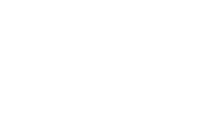

Download Attachments from HPS_LEDChangeOut [Y,N]n


<Item title:"public_GRUAddressPoints" type:Feature Layer Collection owner:siteadmin>

Download Attachments from public_GRUAddressPoints [Y,N]n


<Item title:"ElectricDamageAssessmentPie" type:Feature Layer Collection owner:siteadmin>
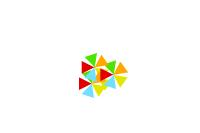

Download Attachments from ElectricDamageAssessmentPie [Y,N]n


<Item title:"WiresDown" type:Feature Layer Collection owner:siteadmin>

Download Attachments from WiresDown [Y,N]n


<Item title:"mmReliabilityPatrol" type:Feature Layer Collection owner:siteadmin>

Download Attachments from mmReliabilityPatrol [Y,N]n


<Item title:"HPS_LEDMapGrid" type:Feature Layer Collection owner:siteadmin>
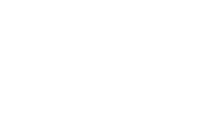

Download Attachments from HPS_LEDMapGrid [Y,N]n


<Item title:"HurricaneMichaelAssessments" type:Feature Layer Collection owner:siteadmin>

Download Attachments from HurricaneMichaelAssessments [Y,N]y


In [7]:
for i in range(len(searchResult)):
    display(searchResult[i])
    updateResult = input(f'Download Attachments from {(searchResult[i].title)} [Y,N]')
    if updateResult.upper() in "YES":
        sdItem = searchResult[i]
        #print(sdItem.title, sdItem.id, sdItem.modified, sdItem.access)
        break
if updateResult.upper() not in "YES":
    print(f'All Service Definitions in your Content on {portal_desc["portalName"]} were presented')
FeatureLayerId = sdItem.id

In [8]:
SaveAttachmentsTo = input(f'Where do you want your attachments stored?')

Where do you want your attachments stored?C:\Users\friendde\Documents\ArcGIS\Projects\UpdateDamageAssesment\Attachments


In [9]:
print(f'How do you want your attachments stored?\nOptions are GroupedFolder or IndividualFolder')
print(f'GroupedFolder - Attachments from every feature in each layer is stored in the same folder\n\tattachments are renamed in the format OBJECTID-ATTACHMENTID-OriginalFileName')
print(f'IndividualFolder - A new folder is created for each OBJECTID, and associated attachments are stored in that folder\n\tattachments are renamed in the format ATTACHMENTID-OriginalFileName')

How do you want your attachments stored?
Options are GroupedFolder or IndividualFolder
GroupedFolder - Attachments from every feature in each layer is stored in the same folder
	attachments are renamed in the format OBJECTID-ATTACHMENTID-OriginalFileName
IndividualFolder - A new folder is created for each OBJECTID, and associated attachments are stored in that folder
	attachments are renamed in the format ATTACHMENTID-OriginalFileName


In [10]:
AttachmentStorage = input(f'Enter GroupedFolder or IndividualFolder')

Enter GroupedFolder or IndividualFolderGroupedFolder


In [11]:
#Create specified folder if it does not exist already
createFolder(SaveAttachmentsTo)
createFolder(SaveLogsTo)

In [27]:
downloadCounter = 0
nonDownloadCounter = 0
downloadSizeCounter = 0

itemObject = gis.content.get(FeatureLayerId)
logger.info(f'Iterating through layers in Feature Layer {itemObject.title}')
display(itemObject)

INFO:__main__:Iterating through layers in Feature Layer HurricaneMichaelAssessments


<Item title:"HurricaneMichaelAssessments" type:Feature Layer Collection owner:siteadmin>

In [20]:
logger.info(f'Script Starting at {str(datetime.datetime.now())}')
#Loop through layers in Feature Layer
for i in range(len(itemObject.layers)):
    featureLayer = itemObject.layers[i]
    
    #Skip layer if attachments are not enabled
    if featureLayer.properties.hasAttachments == True:
        #Remove any characters from feature layer name that may cause problems and ensure it's unique...
        featureLayerName = f"{str(i)}-{re.sub(r'[^A-Za-z0-9]+', '', featureLayer.properties.name)}"
        featureLayerFolder = SaveAttachmentsTo + r'\\' + featureLayerName
        createFolder(featureLayerFolder)

        #Query to get list of object ids in layer
        featureObjectIds = featureLayer.query(where='1=1', return_ids_only=True)

        #Provide some updates to user...
        logger.info(f'Time: {str(datetime.datetime.now())}')
        logger.info(f'Currently looping through feature attachments in layer {str(i + 1)} of {str(len(itemObject.layers))}: storing in folder named {featureLayerName}')
        logger.info(f"There are {str(len(featureObjectIds['objectIds']))} features in this layer")
                                     
logger.info(f'Summary: {downloadCounter} new files have been downloaded totalling {(downloadSizeCounter/1000000)}MB')
logger.info(f'Summary: {nonDownloadCounter} attachments already existed so were not downloaded again')

INFO:__main__:Script Starting at 2019-05-02 21:35:08.933382
INFO:__main__:Time: 2019-05-02 21:35:09.377550
INFO:__main__:Currently looping through feature attachments in layer 1 of 1: storing in folder named 0-HurricaneMichaelAssessments
INFO:__main__:There are 51 features in this layer
